In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from sklearn.covariance import MinCovDet
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from matplotlib.colors import TwoSlopeNorm, LogNorm
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
def showMissing(df):
    """ Show features with missing values """
    nullOrd = df.isnull().sum().sort_values(ascending=False)
    nullOrd = nullOrd[nullOrd > 0]
    nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
    nullOrd['PropNA'] = nullOrd['TotalNA'] / len(X)
    return nullOrd


def computeCorrelation(df, p=0.05):
    """ Compute pairwise correlation, p-value and pair counts """
    correlations = []
    for method in ['kendall', kendalltaur_pval, countPair]:
        values = df.corr(method=method).stack()
        correlations.append(values)
    correlations = (
        pd.concat(correlations, axis=1)
        .reset_index()
        .rename(columns={'level_0': 'feature1',
                         'level_1': 'feature2',
                         0: 'R', 1: 'p', 2: 'n'}))
    correlations['significant'] = correlations['p'] < p
    correlations = correlations[correlations['feature1'] != correlations['feature2']]
    return correlations


def kendalltaur_pval(x,y):
    try:
        return kendalltau(x,y)[1]
    except ValueError:
        return np.nan


def countPair(x, y):
    """ Return count of valid pairs (both not nan) """

    # Indices where both x and y are NOT np.nan
    validIndices = np.intersect1d(
        np.where(~np.isnan(x)),
        np.where(~np.isnan(y)))
    return len(validIndices)


def plotTargetCorrelation(correlations, feature, out=None):
    """ Plot correlations relative to feature """
    targetCorr = (
        correlations.loc[correlations['feature1'] == feature]
        .set_index('feature2'))
    targetCorr = targetCorr.sort_values(by=['p'], ascending=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    targetCorr = targetCorr.loc[targetCorr.index != targetCorr['feature1']]
    sns.heatmap(pd.DataFrame(targetCorr['R']), yticklabels=1, cmap='bwr',
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(left=True)
    sns.heatmap(pd.DataFrame(targetCorr['p']), yticklabels=1,
                cmap='viridis_r', norm=LogNorm(vmax=1), ax=ax2)
    ax2.tick_params(left=True)
    ax2.set_ylabel('')
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, (ax1, ax2)


def plotPairwiseCorrelation(correlations, out=None):
    """ Plot pairwise correlation matrix with
        output from computeCorrelation() """
    wideCorr = correlations.pivot(
        columns='feature1', index='feature2', values='R')
    fig, ax = plt.subplots()
    sns.heatmap(wideCorr, yticklabels=1, cmap='bwr', square=True,
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_facecolor('lightgrey')
    ax.tick_params(left=True)
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, ax


In [5]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)
warnings.filterwarnings('ignore')

In [6]:
train = 'train.csv'
test = 'test.csv'
index = 'PassengerId'
target = 'Survived'

In [7]:
dtypes = ({
    'Survived': bool, 
    'Pclass':   int, 
    'Name':     str,
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
X = pd.read_csv(train, index_col=index, dtype=dtypes)

In [8]:
# Perform ordinal encoding here if necessary, 

In [9]:
allCorrelations = computeCorrelation(X)

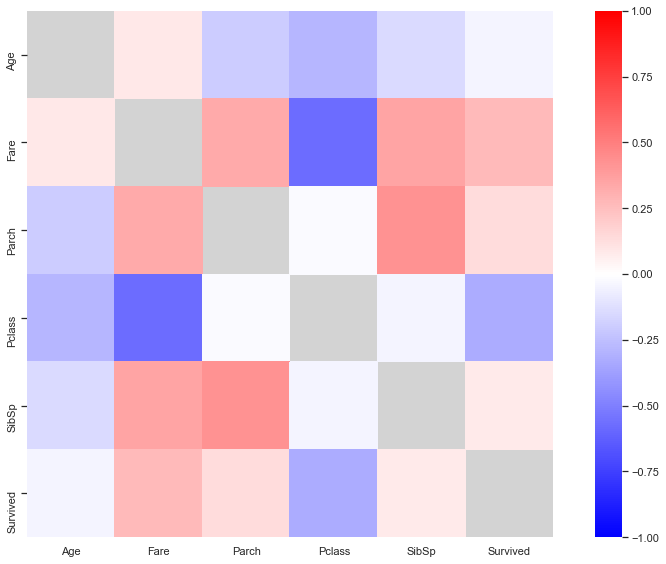

In [10]:
fig, ax = plotPairwiseCorrelation(allCorrelations)

In [11]:
missingVals = showMissing(X)
print(missingVals)

          TotalNA    PropNA
Cabin         687  0.771044
Age           177  0.198653
Embarked        2  0.002245


(<Figure size 864x576 with 4 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

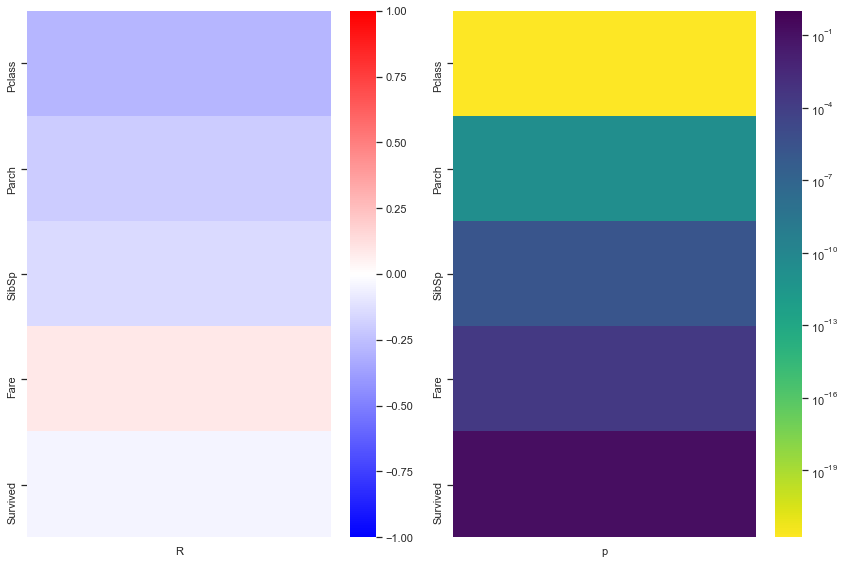

In [12]:
plotTargetCorrelation(allCorrelations, 'Age')

In [13]:
reference = 'Age'
validFeatures = X.select_dtypes(exclude=['float', 'int']).columns
for feature in validFeatures:
    if feature == reference:
        continue
    grouping = [group[reference].dropna().values for _, group in X.groupby(feature)]
    H, p = stats.kruskal(*grouping)
    if not np.isnan(H):
        print(feature, H, p)

Survived 1.970097978146391 0.16043746252207006
Sex 4.951032159109385 0.02607509661801354
Embarked 1.2484133404393043 0.5356862358343728


 https://medium.com/analytics-vidhya/scikit-learn-pipelines-with-custom-transformer-a-step-by-step-guide-9b9b886fd2cc
        https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression, Lasso, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [180]:
set_config(display='diagram')
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

In [181]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """ Extension of SimpleImputer to impute values by group """
    
    def __init__(self, variable, by, strategy='median'): 
        self.variable = variable
        self.by = by
        if strategy == 'most_frequent':
            self.strategy = lambda x: x.mode().sample(1)
        else:
            self.strategy = strategy

    def fit(self, X, y=None):
        self.map = X.groupby(self.by)[self.variable].agg(self.strategy)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        fillValues = X[self.by].apply(tuple, axis=1).map(self.map)
        X[self.variable] = X[self.variable].fillna(fillValues)
        return X

In [182]:
PclassTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
SexTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot' , OneHotEncoder(handle_unknown='ignore'))
])
AssocTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])
FareTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  RobustScaler()),
    ('power',   PowerTransformer(method='yeo-johnson'))
])

In [183]:
transformers = ([
    ('Pclass', PclassTransformer, ['Pclass']),
    ('Sex', SexTransformer, ['Sex']),
    ('Associates', AssocTransformer, ['SibSp', 'Parch']),
    ('Fare', FareTransformer, ['Fare'])
])
preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [184]:
pipeline = Pipeline(steps=[
    ('ageImputer', GroupImputer('Age', by=['Pclass', 'Sex'], strategy='median')),
    ('preprocessor', preprocessor),
    ('classifier',   LogisticRegression(random_state=0))
])

In [191]:
split = train_test_split(X, y, random_state=0, train_size=0.8, test_size=0.2)
X_train, X_valid, y_train, y_valid = map(lambda x: x.copy(), split)

In [192]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('ageImputer',
                 GroupImputer(by=['Pclass', 'Sex'], variable='Age')),
                ('preprocessor',
                 ColumnTransformer(transformers=[('Pclass',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Pclass']),
                                                 ('Sex',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex']),
                                                 ('Associates',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['SibSp', 'Parch']),
                                                 ('Fare',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['Fare'])])),
                ('classifier', LogisticRegression(random_state=0))])

In [194]:
# Define custom score based on Kaggle competition
def kaggleLoss(y_true, y_pred):
    return mean_squared_error(np.log(y_true), np.log(y_pred), squared=False)
kaggleScore = make_scorer(kaggleLoss, greater_is_better=False)

In [195]:
predictions = pipeline.predict(X_valid)
score = kaggleLoss(y_valid, predictions)
fig, ax = plt.subplots()
ax.plot([y_valid.min(), y_valid.max()],
        [y_valid.min(), y_valid.max()],
        '--r', linewidth=2, alpha=0.75)
sns.scatterplot(x=y_valid, y=predictions, ax=ax)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title(f'{name} (score = {score:.4f})', loc='left')
fig.tight_layout()

ValueError: Input contains NaN, infinity or a value too large for dtype('float16').

In [197]:
predictions - y_train

ValueError: ((712,), (179,))